# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 20.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r20-0-0`.

### Test case LVV-T38: Verify implementation of Processed Visit Images
Verify that the DMS
1. Successfully produces Processed Visit Images, where the instrument signature has been removed.
2. Successfully combines images obtained during a standard visit.

### Test case LVV-T42: Verify implementation of Processed Visit Image Content
Verify that Processed Visit Images produced by the DRP and AP pipelines include the observed data, a mask array, a variance array, a PSF model, and a WCS model.

In [1]:
# Confirm that the version of the Science Pipelines is v20_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


In [2]:
import lsst.daf.persistence as dafPersist
# import lsst.daf.butler as dafButler ### Gen 3 Butler
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)
import lsst.daf.persistence as dafPersist ### Gen 2 Butler (dafPersist.Butler)
import lsst.afw.display as afwDisplay
import lsst.geom as geom

In [3]:
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 14})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

### Load and examine some DECam difference images from HiTS

In [4]:
# Meredith pointed me to where she regularly re-runs HiTS data through diff imaging:
diffim_repo = '/project/mrawls/hits2015/rerun/cw_2020_06'

In [5]:
butler = dafPersist.Butler(diffim_repo)

In [6]:
# Pick a visit/ccd at random:
dataId = {'visit': 411406, 'ccd': 15}

# Load the calexp image
calexp = butler.get('calexp', **dataId)

# Load the raw image
raw = butler.get('raw', **dataId)

In [7]:
# Extract the images and normalize them:
im = calexp.image.array

# Create an ImageNormalize object
norm = ImageNormalize(im, interval=ZScaleInterval(),
                      stretch=LinearStretch())

rawim = raw.image.array

# Create an ImageNormalize object
rawnorm = ImageNormalize(rawim, interval=ZScaleInterval(),
                         stretch=LinearStretch())

### Compare the original image and the processed visit image (aka "calexp")

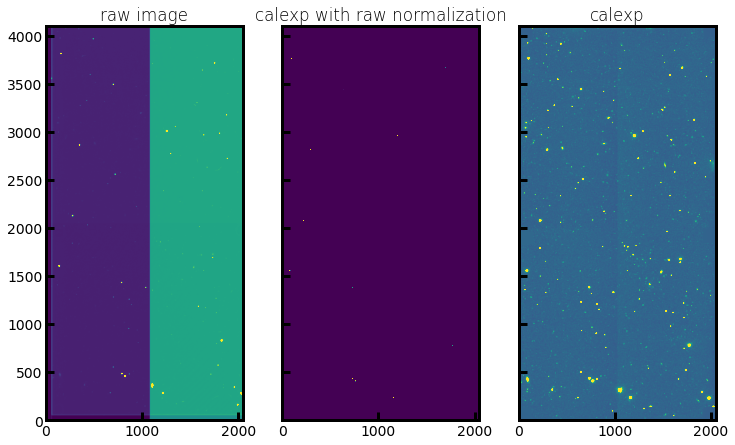

In [8]:
ncols = 3
nrows = 1
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axs = ax.flatten()

axs[0].imshow(rawim, norm=rawnorm, origin='lower')
axs[0].set_title('raw image')
axs[1].imshow(im, norm=rawnorm, origin='lower')
axs[1].set_title('calexp with raw normalization')
axs[2].imshow(im, norm=norm, origin='lower')
axs[2].set_title('calexp')
plt.show()

### Confirm that the processed visit image (aka "calexp") contains mask and variance planes

In [9]:
# Extract the images and normalize them:
mask = calexp.maskedImage

# Extract the images and normalize them:
variance = calexp.variance.array

# Create an ImageNormalize object
variancenorm = ImageNormalize(variance, interval=ZScaleInterval(),
                              stretch=LinearStretch())


#### Display the variance plane:

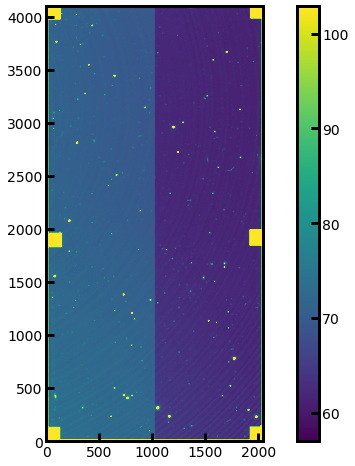

In [10]:
plt.imshow(variance, norm=variancenorm, origin='lower')
plt.colorbar()
plt.show()

#### Display the masked image:

<Figure size 864x576 with 0 Axes>

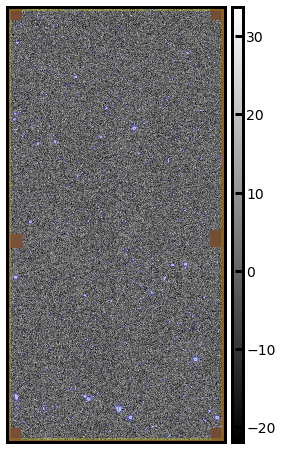

In [11]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(mask)
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
# The MaskedImage is overplotting the values of the mask plane. 
# Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in mask.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))


red: BAD
magenta: CR
None: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
green: INTRP
orange: NO_DATA
green: SAT
yellow: SUSPECT
None: UNMASKEDNAN


The masked image looks good and well-formed, so this portion of the test passes.

#### Confirm that the WCS is present with the calexp

In [13]:
# First, check the result of the "hasWcs" method:
calexp.hasWcs()

True

In [14]:
# OK, the Butler claims that the calexp has a WCS. Now check the WCS.

# Load the source catalog
src = butler.get('src', dataId = dataId)

# Extract the WCS+calexp and match to Gaia:
wcs = calexp.getWcs()

# Start from XY, then use the WCS to convert to RA, Dec:
xxx = src.getX()
yyy = src.getY()
radec = [wcs.pixelToSky(xxx[i], yyy[i]) for i in range(len(xxx))]

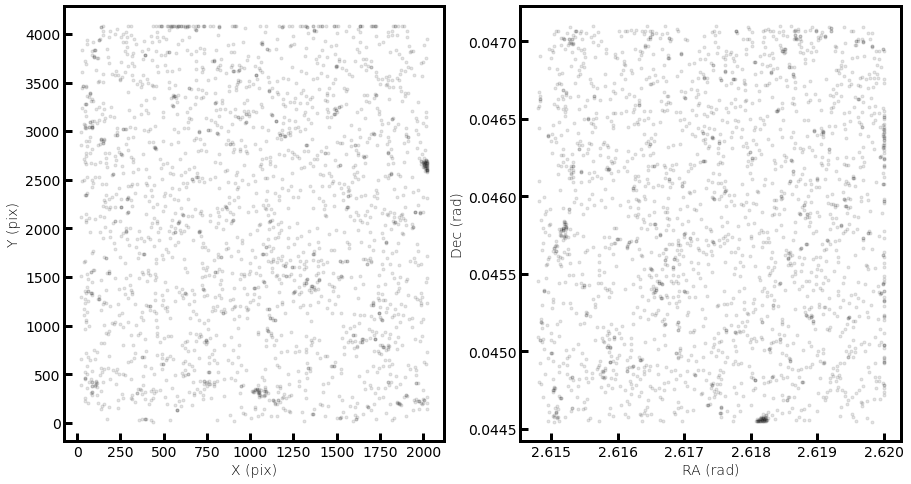

In [15]:
plt.rcParams.update({'figure.figsize' : (15, 8)})

plt.subplot(121)
plt.plot(xxx, yyy, 'k.', alpha=0.1)
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

plt.subplot(122)
for r in radec:
    plt.plot(r.getRa(), r.getDec(), 'k.', alpha=0.1)

plt.xlabel('RA (rad)')
plt.ylabel('Dec (rad)')
plt.show()

In [31]:
# Confirm that the position given by the WCS is reasonably close to what we see in the right panel above:
print(wcs.getSkyOrigin().getRa(), wcs.getSkyOrigin().getDec())

2.61734 rad 0.0457772 rad


The positions seem to have reasonably converted from (X, Y) to (RA, Dec). We thus consider this portion of the test to have passed.

#### Confirm that the PSF is available and can be extracted

In [16]:
calexp.hasPsf()

True

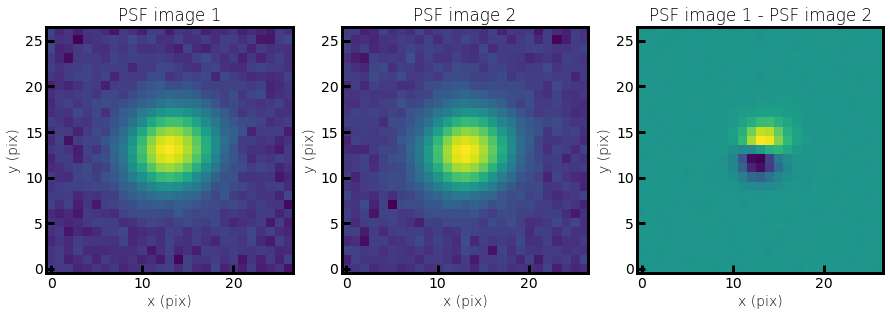

In [20]:
# Extract an image of the PSF at two random points and display them:
psf = calexp.getPsf()

xsize = calexp.getDimensions().getX()
ysize = calexp.getDimensions().getY()
# Select a random point on the image and extract the PSF at that point:
xpt1 = random.random()*xsize
ypt1 = random.random()*ysize
psfimage1 = psf.computeImage(geom.PointD(xpt1, ypt1))
img1 = psfimage1.array

xpt2 = random.random()*xsize
ypt2 = random.random()*ysize
psfimage2 = psf.computeImage(geom.PointD(xpt2, ypt2))
img2 = psfimage2.array

# Create an ImageNormalize object
norm1 = ImageNormalize(img1, interval=MinMaxInterval(),
                       stretch=LogStretch())
norm2 = ImageNormalize(img2, interval=MinMaxInterval(),
                       stretch=LogStretch())

plt.subplot(131)

plt.imshow(img1, norm=norm1, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('PSF image 1')
plt.subplot(132)
plt.imshow(img2, norm=norm2, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('PSF image 2')
plt.subplot(133)
plt.imshow(img1-img2, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('PSF image 1 - PSF image 2')

plt.show()

The first two panels show well-formed images of a reasonable-looking PSF. 

The third panel, showing the difference of the two PSF from random positions, illustrates that the PSF differs with position.

We thus consider this portion of the test to have passed.

We have now confirmed that a randomly-selected Processed Visit Image (aka "calexp") has image, mask, and variance planes, and an associated WCS and PSF that behave as expected.

### Check all of the above, but now for a difference image:

In [32]:
# Load the difference image
diffexp = butler.get('deepDiff_differenceExp', **dataId)

In [34]:
# Extract the images and normalize them:
im = diffexp.image.array

# Create an ImageNormalize object
norm = ImageNormalize(im, interval=ZScaleInterval(),
                      stretch=LinearStretch())

### Compare the original (raw) image and the difference image

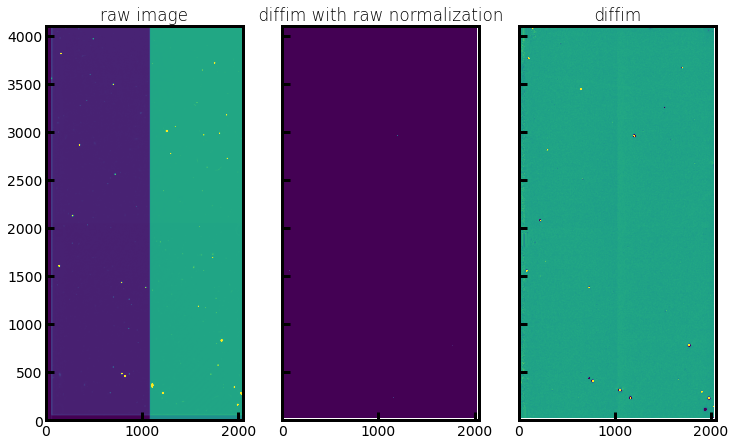

In [37]:
ncols = 3
nrows = 1
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axs = ax.flatten()

axs[0].imshow(rawim, norm=rawnorm, origin='lower')
axs[0].set_title('raw image')
axs[1].imshow(im, norm=rawnorm, origin='lower')
axs[1].set_title('diffim with raw normalization')
axs[2].imshow(im, norm=norm, origin='lower')
axs[2].set_title('diffim')
plt.show()

### Confirm that the processed visit image (aka "calexp") contains mask and variance planes

In [40]:
# Extract the images and normalize them:
mask = diffexp.maskedImage

# Extract the images and normalize them:
variance = diffexp.variance.array

# Create an ImageNormalize object
variancenorm = ImageNormalize(variance, interval=ZScaleInterval(),
                              stretch=LinearStretch())


#### Display the variance plane of the difference image:

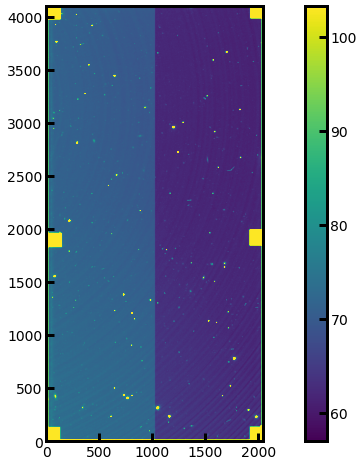

In [41]:
plt.imshow(variance, norm=variancenorm, origin='lower')
plt.colorbar()
plt.show()

#### Display the masked diffim:

<Figure size 1080x576 with 0 Axes>

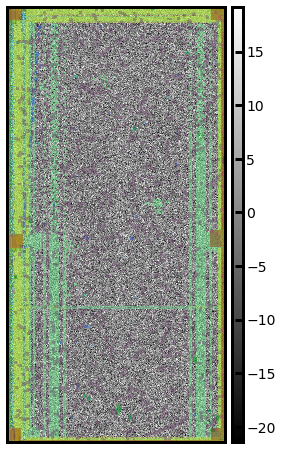

In [42]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(mask)
plt.xticks([])
plt.yticks([])
plt.show()

In [43]:
# The MaskedImage is overplotting the values of the mask plane. 
# Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in mask.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))

red: BAD
None: CLIPPED
magenta: CR
None: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
None: INEXACT_PSF
green: INTRP
None: NOT_DEBLENDED
orange: NO_DATA
None: REJECTED
green: SAT
None: SENSOR_EDGE
yellow: SUSPECT
None: UNMASKEDNAN


#### Confirm that the WCS is present with the diffim:

In [46]:
# First, check the result of the "hasWcs" method:
diffexp.hasWcs()

True

In [48]:
# OK, the Butler claims that the calexp has a WCS. Now check the WCS.

# Load the source catalog
src = butler.get('deepDiff_diaSrc', **dataId)

# Extract the WCS+calexp and match to Gaia:
wcs = diffexp.getWcs()

# Start from XY, then use the WCS to convert to RA, Dec:
xxx = src.getX()
yyy = src.getY()
radec = [wcs.pixelToSky(xxx[i], yyy[i]) for i in range(len(xxx))]

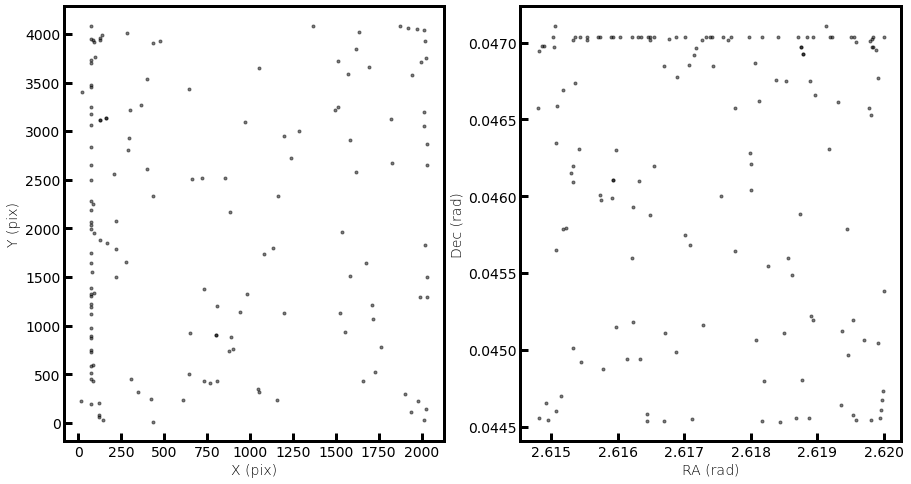

In [50]:
plt.rcParams.update({'figure.figsize' : (15, 8)})

plt.subplot(121)
plt.plot(xxx, yyy, 'k.', alpha=0.5)
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

plt.subplot(122)
for r in radec:
    plt.plot(r.getRa(), r.getDec(), 'k.', alpha=0.5)

plt.xlabel('RA (rad)')
plt.ylabel('Dec (rad)')
plt.show()

In [51]:
# Confirm that the position given by the WCS is reasonably close to what we see in the right panel above:
print(wcs.getSkyOrigin().getRa(), wcs.getSkyOrigin().getDec())

2.61734 rad 0.0457772 rad


#### Confirm that the diffim has associated PSF that is well-formed:

In [52]:
diffexp.hasPsf()

True

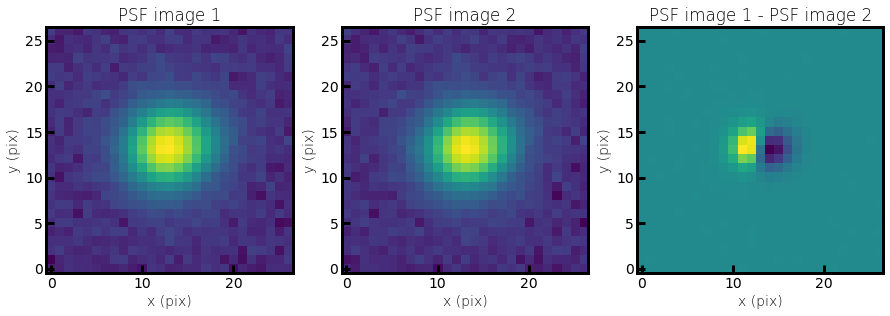

In [53]:
# Extract an image of the PSF at two random points and display them:
psf = diffexp.getPsf()

xsize = diffexp.getDimensions().getX()
ysize = diffexp.getDimensions().getY()
# Select a random point on the image and extract the PSF at that point:
xpt1 = random.random()*xsize
ypt1 = random.random()*ysize
psfimage1 = psf.computeImage(geom.PointD(xpt1, ypt1))
img1 = psfimage1.array

xpt2 = random.random()*xsize
ypt2 = random.random()*ysize
psfimage2 = psf.computeImage(geom.PointD(xpt2, ypt2))
img2 = psfimage2.array

# Create an ImageNormalize object
norm1 = ImageNormalize(img1, interval=MinMaxInterval(),
                       stretch=LogStretch())
norm2 = ImageNormalize(img2, interval=MinMaxInterval(),
                       stretch=LogStretch())

plt.subplot(131)

plt.imshow(img1, norm=norm1, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('PSF image 1')
plt.subplot(132)
plt.imshow(img2, norm=norm2, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('PSF image 2')
plt.subplot(133)
plt.imshow(img1-img2, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.title('PSF image 1 - PSF image 2')

plt.show()